![image](https://docs.google.com/uc?export=download&id=1Nh6vjig-ADM1RMbaHrj_GItD3O1ZW4Vr)
# **Taller No. 3**
## **Selección de Variables e Introducción a la Minería de Texto**

## **Objetivos**<a name="id1"></a>
- Aprender a utilizar la regresión logística como modelo de selección
- Introducirnos al procesamiento de textos y a la minería.

## **Problema**<a name="id2"></a>
- En un hospital buscan clasificar los distintos abscesos mamarios en las mujeres, y para eso, se busca automatizar el proceso de caracterización de un tumor.

## **Notebook Configuration**

In [16]:
%%shell
shred -u setup_colab_general.py
wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
pip install -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
pip install -q tqdm==4.56.0

In [17]:
import setup_colab_general as setup_general
setup_general.setup_general()


General Functions Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**

In [18]:
import numpy as np
import pandas as pd

import pandas_profiling

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
%matplotlib inline
import seaborn as sns

from utils import general as gen

import re

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import (classification_report, precision_score, 
                             recall_score, f1_score, confusion_matrix)
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

## **Visualización y Perfilamiento**

In [19]:
breast_data = datasets.load_breast_cancer()

In [20]:
breast_data.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [21]:
total_data = pd.concat([
    pd.DataFrame(breast_data.data, columns=breast_data.feature_names),
    pd.DataFrame(breast_data.target, columns=["target"])
], axis=1)

total_data["target"] = (total_data["target"] == 0).astype("int")

In [22]:
total_data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [ ]:
pandas_profiling.ProfileReport(total_data,
                               minimal=True)

Output hidden; open in https://colab.research.google.com to view.

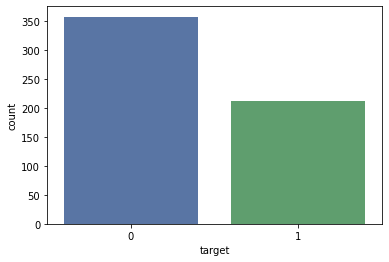

In [23]:
sns.countplot(x=total_data["target"])
plt.show()

In [24]:
total_data["target"].value_counts()

0    357
1    212
Name: target, dtype: int64

In [25]:
total_data["target"].mean(), 1 - total_data["target"].mean()

(0.37258347978910367, 0.6274165202108963)

## **Separación de los Datos**

In [111]:
X = total_data.drop("target", axis=1)
y = total_data["target"]

In [112]:
stratified_splitter = StratifiedShuffleSplit(test_size=0.2, random_state=1234)

In [113]:
for full_train_index, test_index in stratified_splitter.split(X, y):
    full_X_train, full_y_train = X.iloc[full_train_index], y.iloc[full_train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

In [114]:
stratified_splitter = StratifiedShuffleSplit(test_size=0.2, random_state=5678)

In [115]:
for train_index, val_index in stratified_splitter.split(full_X_train, full_y_train):
    X_train, y_train = full_X_train.iloc[train_index], full_y_train.iloc[train_index]
    X_val, y_val = full_X_train.iloc[val_index], full_y_train.iloc[val_index]

In [116]:
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [117]:
y_train.mean(), 1 - y_train.mean()

(0.37362637362637363, 0.6263736263736264)

In [118]:
y_val.mean(), 1 - y_val.mean()

(0.37362637362637363, 0.6263736263736264)

In [119]:
y_test.mean(), 1 - y_test.mean()

(0.3684210526315789, 0.631578947368421)

## **Preparación de los Datos**

### **Detección de Outliers**

In [ ]:
LocalOutlierFactor?

In [120]:
outlier_factor = LocalOutlierFactor()
y_pred = outlier_factor.fit_predict(X_train)
X_score = outlier_factor.negative_outlier_factor_

In [121]:
(X_score < -2.0).sum()

8

In [122]:
outlier_df = pd.DataFrame(X_score, columns=["score"])

In [123]:
outlier_df

,score
0,-1.047388
1,-0.997411
2,-1.036168
3,-1.090982
4,-1.018596
...,...
359,-1.006949
360,-0.996039
361,-1.005045
362,-1.029025


In [124]:
X_train = X_train.loc[outlier_df.query("score > -2.0").index]
y_train = y_train.loc[outlier_df.query("score > -2.0").index]

In [125]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [126]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [127]:
X_train = pd.DataFrame(data=X_train, 
                       columns=total_data.drop("target", 
                                               axis=1).columns)

In [128]:
def pipeline(X_data, y_data):
    X_data.reset_index(inplace=True, drop=True)
    y_data.reset_index(inplace=True, drop=True)

    scaler = StandardScaler()
    X_data = scaler.fit_transform(X_data)
    X_data = pd.DataFrame(data=X_data, 
                          columns=total_data.drop("target", 
                                                  axis=1).columns)
    outlier_factor = LocalOutlierFactor()
    outlier_factor.fit(X_data)
    X_score = outlier_factor.negative_outlier_factor_

    outlier_df = pd.DataFrame(X_score, columns=["score"])

    X_data = X_data.loc[outlier_df.query("score > -2.0").index]
    y_data = y_data.loc[outlier_df.query("score > -2.0").index]

    X_data.reset_index(inplace=True, drop=True)
    y_data.reset_index(inplace=True, drop=True)
    return X_data, y_data

## **Modelamiento**</a>
- A la hora de modelar los datos, buscamos un algoritmo que generalice la forma como los datos se comportan y con base en ello, pueda generar predicciones.

### **K-Nearest-Neighbors**
- En este caso, vamos a utilizar un algoritmo de modelado no lineal basado en vecindades o *neighborhoods*. Se trata de *K-Nearest Neighbors*.

![image](https://miro.medium.com/max/3544/1*4F-q86XFr2-EsaAcz0Zu5A.png)

> Tomado de [Towards Data Science](https://towardsdatascience.com/k-nearest-neighbor-python-2fccc47d2a55)

- Este espacio lo tomamos, generalmente, para buscar algoritmos que puedan ser usados para modelar, y una vez encontrados, exploramos los hiperparámetros que podamos usar para mejorar los resultados de nuestras predicciones.

### **Sin Selección de Variables**

In [129]:
X_val, y_val = pipeline(X_val, y_val)

In [130]:
knn_clf = KNeighborsClassifier().fit(X_train, y_train)

In [131]:
y_pred = knn_clf.predict(X_val)

In [132]:
clf_report = classification_report(y_val, y_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        57
           1       1.00      0.97      0.98        32

    accuracy                           0.99        89
   macro avg       0.99      0.98      0.99        89
weighted avg       0.99      0.99      0.99        89



In [133]:
precision_score(y_val, y_pred)

1.0

In [134]:
recall_score(y_val, y_pred)

0.96875

In [135]:
f1_score(y_val, y_pred)

0.9841269841269841

### **Selección de Variables**
#### **Matriz de Correlación de Pearson**

$$\rho_{X,Y}={\sigma_{XY} \over \sigma_{X} \sigma_{Y}}={\frac {\operatorname {Cov} (X,Y)}{\sqrt {\operatorname {Var} (X)\operatorname {Var} (Y)}}}$$

In [ ]:
correlation_matrix = total_data.corr(method="pearson")

thresh = 0.7

filter = (correlation_matrix["target"] > thresh) | (correlation_matrix["target"] < -thresh)
correlated_features = correlation_matrix.columns[filter].tolist()

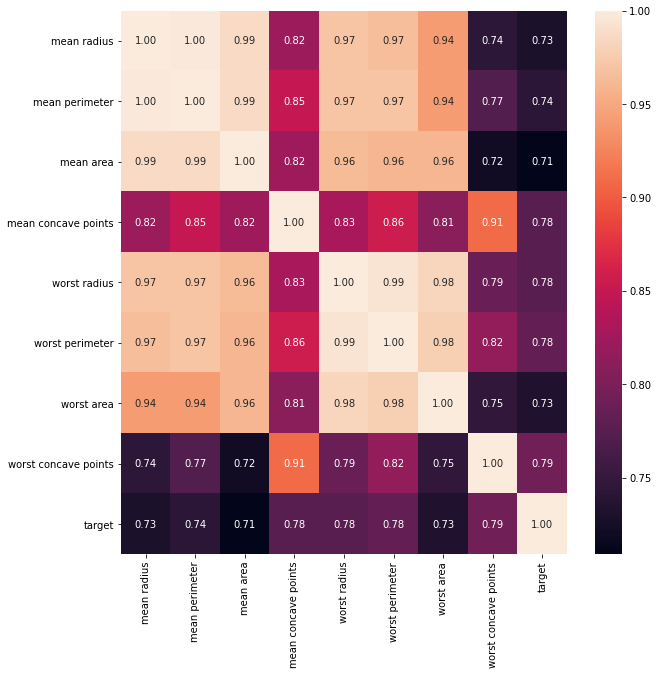

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(total_data[correlated_features].corr(), annot=True, fmt=".2f")
plt.show()

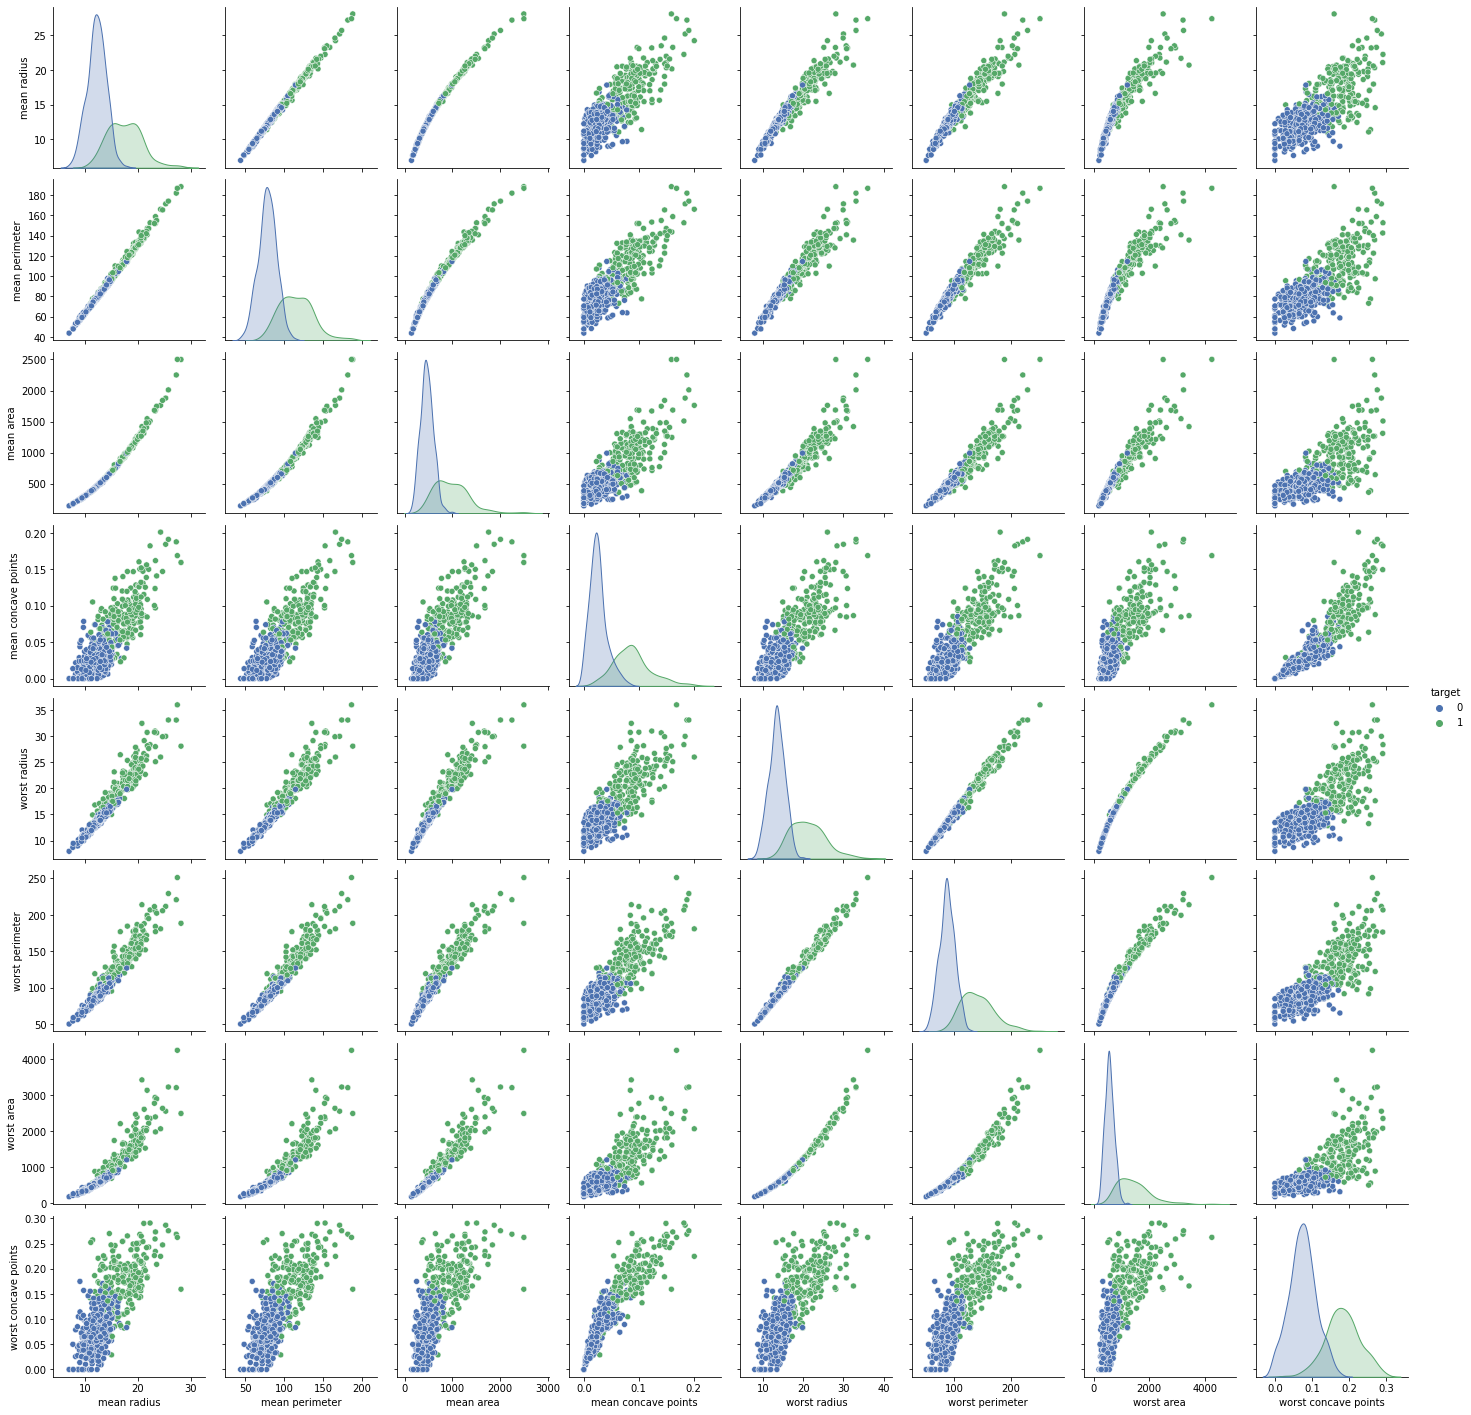

In [ ]:
sns.pairplot(total_data[correlated_features], diag_kind="kde", hue="target")
plt.show()

#### **Regresión Logística**

- Función Sigmoidea
$$ f(x) = \frac {1} {1 + e ^ {-x}}$$

In [136]:
log_reg = LogisticRegression().fit(X_train, y_train)

In [137]:
importances = pd.DataFrame(
    data={
        "Attribute": X_train.columns,
        "Importance": log_reg.coef_[0]
    }
)
importances = importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

In [138]:
importances

,Attribute,Importance
0,worst concave points,1.241217
1,radius error,1.046238
2,mean concave points,0.904195
3,area error,0.861716
4,worst texture,0.860141
5,perimeter error,0.793267
6,worst area,0.778510
7,mean concavity,0.758581
8,worst radius,0.757766
9,mean texture,0.721523


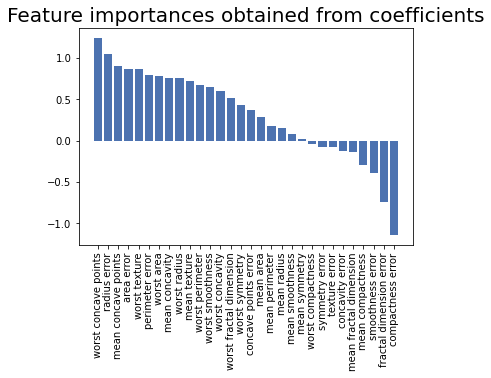

In [139]:
plt.bar(x=importances['Attribute'], height=importances['Importance'])
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [140]:
importances.query("Importance > 0.7 or Importance < -0.7")

,Attribute,Importance
0,worst concave points,1.241217
1,radius error,1.046238
2,mean concave points,0.904195
3,area error,0.861716
4,worst texture,0.860141
5,perimeter error,0.793267
6,worst area,0.778510
7,mean concavity,0.758581
8,worst radius,0.757766
9,mean texture,0.721523


In [141]:
X_train = X_train[importances.query("Importance > 0.7 or Importance < -0.7")["Attribute"].values]
X_val = X_val[importances.query("Importance > 0.7 or Importance < -0.7")["Attribute"].values]

In [142]:
X_train.head()

,worst concave points,radius error,mean concave points,area error,worst texture,perimeter error,worst area,mean concavity,worst radius,mean texture,fractal dimension error,compactness error
0,1.361261,1.106315,0.315958,1.611982,1.445546,0.996143,2.094194,0.198828,1.902688,0.510572,0.208281,0.705821
1,-0.945133,-0.617741,-0.799962,-0.696117,-0.459527,-0.684205,-0.979254,-0.916216,-1.115956,-0.406749,-0.030510,-0.664062
2,-0.845017,-1.015299,-0.953918,-0.728279,-0.631364,-0.837580,-0.274622,-0.858646,-0.219620,-0.620791,-0.612129,-0.710694
3,-0.897628,-0.097255,-0.525726,-0.400037,-0.776764,-0.210529,-0.733772,-0.825063,-0.741166,-0.333834,-0.153747,-0.785305
4,1.231280,0.063599,1.890273,0.138204,0.356697,0.228653,0.926309,2.886701,1.058280,0.414136,0.436600,0.607620


In [143]:
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [144]:
y_pred = knn_clf.predict(X_val)

In [145]:
clf_report = classification_report(y_val, y_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        57
           1       1.00      0.97      0.98        32

    accuracy                           0.99        89
   macro avg       0.99      0.98      0.99        89
weighted avg       0.99      0.99      0.99        89



In [146]:
precision_score(y_val, y_pred)

1.0

In [147]:
recall_score(y_val, y_pred)

0.96875

In [148]:
f1_score(y_val, y_pred)

0.9841269841269841

## **Validación**

In [149]:
X_test, y_test = pipeline(X_test, y_test)

In [150]:
X_test = X_test[importances.query("Importance > 0.7 or Importance < -0.7")["Attribute"].values]

In [151]:
y_pred = knn_clf.predict(X_test)

In [152]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [153]:
pd.DataFrame(conf_matrix)

,0,1
0,70,1
1,5,36


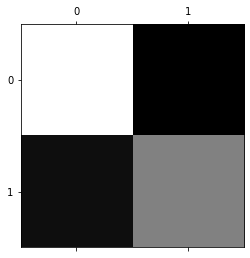

In [154]:
plt.matshow(conf_matrix, cmap="gray")
plt.grid(0)
plt.show()

In [155]:
np.trace(conf_matrix)

106

In [156]:
norm_conf_mat = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mat, 0)

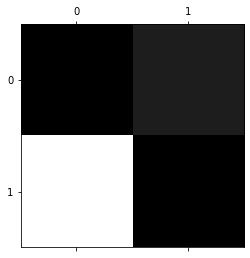

In [157]:
plt.matshow(norm_conf_mat, cmap="gray")
plt.grid(0)
plt.show()

## **Text Mining**
- En este caso, queremos hacer análisis de sentimientos a partir de reseñas hechas por mujeres en una tienda de ropa.

In [ ]:
data_url = "https://github.com/jpcano1/MINE_4206_Analisis_con_Machine_Learning/raw/main/Lab%20III/women_clothing_data.csv"

In [ ]:
gen.download_content(data_url, "women_data.csv")

  0%|          | 0/2855 [00:00<?, ?KB/s]

In [ ]:
data = pd.read_csv("data/women_data.csv", index_col="Unnamed: 0")

In [ ]:
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
pandas_profiling.ProfileReport(data, minimal=True)

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
data.drop(["Clothing ID"], axis=1, inplace=True)

new_columns = ["age", "title", "review", "rating", "recommended", 
               "pos_feed_count", "division", "department", "class"]

data.columns = new_columns

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.head()

,age,title,review,rating,recommended,pos_feed_count,division,department,class
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits


In [ ]:
text_data, data = data.copy().iloc[:, 1: 5], data.drop(["title", "review"], axis=1)

In [ ]:
text_data.head()

,title,review,rating,recommended
2,Some major design flaws,I had such high hopes for this dress and reall...,3,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1
4,Flattering shirt,This shirt is very flattering to all due to th...,5,1
5,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0
6,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1


In [ ]:
text_data.dropna(inplace=True)
text_data.reset_index(drop=True, inplace=True)

data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [ ]:
def preprocess(text):
    text = re.sub(r'@\w+ | http', '', text)
    text = re.sub(r'[^a-zA-Z ]+', ' ', text).strip()
    text = text.lower()
    return text

In [ ]:
text_data["review"] = text_data["review"].apply(lambda x: preprocess(x))
text_data["title"] = text_data["title"].apply(lambda x: preprocess(x))

In [ ]:
text_data.head()

,title,review,rating,recommended
0,some major design flaws,i had such high hopes for this dress and reall...,3,0
1,my favorite buy,i love love love this jumpsuit it s fun fl...,5,1
2,flattering shirt,this shirt is very flattering to all due to th...,5,1
3,not for the very petite,i love tracy reese dresses but this one is no...,2,0
4,cagrcoal shimmer fun,i aded this in my basket at hte last mintue to...,5,1


In [ ]:
vectorizer = CountVectorizer(analyzer='word')
review_counts = vectorizer.fit_transform(text_data["review"].values.tolist())

In [ ]:
tf_transformer = TfidfTransformer(use_idf=False)
review_counts = tf_transformer.fit_transform(review_counts)

In [ ]:
review_data = pd.DataFrame(review_counts.toarray(), 
                           columns=vectorizer.get_feature_names())

In [ ]:
title_counts = vectorizer.fit_transform(text_data["title"].values.tolist())
title_counts = tf_transformer.fit_transform(title_counts)

In [ ]:
title_data = pd.DataFrame(title_counts.toarray(), columns=vectorizer.get_feature_names())

In [ ]:
del review_counts, title_counts

In [ ]:
total_data = pd.concat([data, review_data], axis=1)

In [ ]:
total_data.head()

,age,rating,recommended,pos_feed_count,division,department,class,aa,aaaaaaamazing,aaaaandidon,aaaaannnnnnd,aaaahmazing,aaaahs,aaahed,aame,ab,abbey,abby,abck,abdomen,abdominal,abercrombie,abhor,ability,able,abnormal,abnormally,abo,abolutely,abou,about,above,abroad,abruptly,abs,absence,abso,absolute,absolutely,absolutley,...,yours,yourself,yourselves,youth,youthful,youthfull,yr,yrs,yuck,yucky,yuk,yumi,yummiest,yummy,yup,zag,zara,zermatt,zero,zeros,zig,zigzag,zigzagging,zillion,zip,zipepr,ziploc,zipped,zipper,zippered,zippers,zippie,zipping,zips,zombie,zone,zoolander,zoom,zooming,zuma
0,60,3,0,0,General,Dresses,Dresses,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078811,0.0,0.0,0.0,0.078811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50,5,1,0,General Petite,Bottoms,Pants,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,47,5,1,6,General,Tops,Blouses,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,49,2,0,4,General,Dresses,Dresses,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,39,5,1,1,General Petite,Tops,Knits,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Ejercicios**
1. Utilizando el conjunto de datos del primer problema, explore la selección basada en modelos utilizando un árbol de decisión y la selección secuencial como métodos de selección de variables. Se puede guiar con la siguiente [documentación](https://scikit-learn.org/stable/modules/feature_selection.html) Implementarlos sobre el conjunto de entrenamiento, validarlo con el conjunto de testing y comparar resultados.
2. Utilizar PCA para reducir la dimensionalidad de los datos del segundo problema sobre la tabla de Tf - IdF.
3. Finalmente, utilice los resultados del punto 2 para entrenar un clasificador que permita determinar el rating.